In [11]:
# Import libraries

import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import glob
import scipy.io
import numpy as np
from scipy.stats import matrix_normal as mnn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pickle as pkl
import imageio
from scipy.sparse import csr_matrix
from numpy.linalg import cholesky as chol

In [18]:
def load_data(data_dir):
    """
    Load the real maps
    :param
    data_dir: folder with real data
    """

    real_maps = []
    subject_dirs = []
    for subject_dir in os.listdir(data_dir):
        subject_array = np.load(data_dir + "/" + subject_dir + ("/" + subject_dir + "." + "averageMap.pkl"), allow_pickle=True)
        real_maps.append(subject_array.T)
        subject_dirs.append(subject_dir)

    real_maps = np.array(real_maps)
    subject_dirs = subject_dirs
    data_dir = data_dir
    
    return (real_maps, subject_dirs)

In [19]:
def calculate_global_params(real_maps):
    """
    Calculate the global parameters (xbar, subject variances)
    :return: None
    """

    # Mean map
    xbar = np.mean(np.nanmean(real_maps, axis=1), axis=0)
    real_maps = real_maps - xbar
    # Variance matrix
    subject_var = []
    for subject in real_maps:
        subject_var.append(np.nanmean((np.nanmean(subject, axis=0) -
                                       xbar) ** 2))
    var_s = np.array(subject_var)
    
    return (xbar, var_s)

In [20]:
def calculate_map_params(subject, xbar, data_dir, subject_dir, var_s):
    """
    Calculate the parameters based on the passed subject
    for generating a new map
    :param
    subject: numpy array containing the pixel values for the five fingers
    subject_dir: folder name containing the subject's noise data
    xbar: mean map
    var_s: Variance of the subject mean map from the overall mean

    :return
    subject_component: subject specific component
    finger_component: array with the finger components
    noise_component: noise component for each finger
    noise_visualize: noise maps converted to pixels
    data_dict: dictionary consisting of the above listed components
    """

    # Load subject specific matrices
    matrix_dir = data_dir + "/" + subject_dir + "/"
    mappingFile = matrix_dir + subject_dir + "." + "voxelMappingInfo.pkl"
    with open(mappingFile, 'rb') as mfile:
      mappingFile = pkl.load(mfile)
    vox2pix = np.array(csr_matrix(mappingFile['vox2Pixel']).todense())
    noise_mat = mappingFile['noise_corr']
    avg_Bvar_est = mappingFile['avg_Bvar_est']
    del mappingFile
    
    print ("Subject")
    # Generate Subject specific component
    subject_component = np.mean(subject, axis = 0)
    subject_covariance_matrix = np.dot((subject_component.reshape(-1, 1) -
                                        subject_component.mean()),
                                       (subject_component.reshape(1, -1) -
                                        subject_component.mean())) + np.eye(16384) * 0.0000001

    # Use cholesky decomposition follwed by matrix multiplication to
    # generate the component with the required correlation structure

    a = chol(subject_covariance_matrix)
    z = np.random.normal(0, 1, size = (16384,))
    z = z/np.std(z)
    subject_component = np.dot(a, z)
    subject_component = (subject_component/subject_component.std()) * (np.sqrt(var_s))
    
    print ("Finger")
    # Generate finger specific components
    subject_covariance_matrix = np.dot((subject_component.reshape(16384, 1) -
                                        subject_component.mean()),
                                       (subject_component.reshape(1, 16384) -
                                        subject_component.mean())) + np.eye(16384) * 0.0000001
    finger_covariance_matrix = \
        np.ma.cov(np.ma.masked_invalid(subject - subject.mean(axis=0))) + 0.0000001
    finger_component = mnn.rvs(rowcov=finger_covariance_matrix,
                               colcov=subject_covariance_matrix)
    
    print ("Noise")
    # Generate noise
    noise_list = []
    pixel_noise_list = []
    try:
        for _iter in range(0, 5):
            noise = mnn.rvs(rowcov=noise_mat*avg_Bvar_est)
            noise = noise - noise.mean()
            noise_list.append(noise)
            pixel_noise = np.dot(vox2pix.T, noise)
            pixel_noise_list.append(pixel_noise)
    except Exception as e:
        print (e)
        return -1
    data_dict = {
        "subject_component": subject_component,
        "finger_component": finger_component,
        "noise_component": noise_list,
        "noise_visualize": pixel_noise_list
    }
    
    del noise_list, finger_component, subject_component, 
    pixel_noise_list, noise_mat, subject_covariance_matrix, 
    finger_covariance_matrix
    
    return data_dict

In [26]:
def make_maps(real_maps, subject_dirs, data_dir, save_dir):
    """
    Function to generate maps
    :param save_dir: folder to save the data in
    :return: None
    """
    
    var = {"true_pixel": [],
            "true_voxel": [],
            "noise_pixel": [],
            "noise_voxel": [],
            "components": [],
            "voxel_map": []}
    
    
    xbar, var_s = calculate_global_params(real_maps)
    real_maps = real_maps - xbar
    
    print ("Make Maps")
    generated_maps = []
    for i in range(0, real_maps.shape[0]):
        maps_list = []
        data_dict = calculate_map_params(subject = real_maps[i],
                                         xbar = xbar,
                                         subject_dir = subject_dirs[i],
                                         data_dir = data_dir,
                                         var_s = var_s[i])
        if data_dict == -1:
            continue

        # Load pixel and voxel transformation matrices
        matrix_dir = data_dir + "/" + subject_dirs[i] + "/"
        mappingFile = matrix_dir + subject_dirs[i] + "." + "voxelMappingInfo.pkl"
        with open(mappingFile, 'rb') as mfile:
          mappingFile = pkl.load(mfile)

        vox2pix = np.array(csr_matrix(mappingFile['vox2Pixel']).todense())
        pix2vox = np.array(csr_matrix(mappingFile['pixel2Vox']).todense())
        del mappingFile
        
        # Combine xbar and the subject component
        subject_map = xbar.reshape(128, 128).T + data_dict['subject_component'].reshape(128, 128)
        true_maps = []
        
        # Iterate over the finger components and generate the map for each finger
        for finger in range(0, 5):
            pixel_map = subject_map + data_dict['finger_component'][finger].reshape(128, 128)
            voxel_map = np.dot(pix2vox.T, pixel_map.flatten().reshape(-1, 1))
            true_map = np.dot(vox2pix.T, voxel_map.flatten())
            true_maps.append(true_map.flatten())
            voxel_map = voxel_map + data_dict['noise_component'][finger]
            new_map = np.dot(vox2pix.T, voxel_map.flatten())
            maps_list.append(new_map.flatten())
            var["components"].append([xbar.var(), data_dict['subject_component'].var(),
                                           data_dict['finger_component'][finger].var()])
            var["true_pixel"].append(pixel_map.var())
            var["true_voxel"].append(voxel_map.var())
            var["noise_voxel"].append(data_dict['noise_component'][finger].var())
            var["voxel_map"].append(voxel_map.var())

        data_dict['maps'] = maps_list
        data_dict['true_maps'] = true_maps
        print ("Save")
        save_map(data_dict, subject_dirs[i], save_dir)
        generated_maps.append(maps_list)

    gen_maps = np.array(generated_maps)
    variances = var
    return (gen_maps, variances)

In [27]:
def save_map(data_dict, subject_index, save_dir):
    """
    Save the maps to the specified folder as image, matrix
    :param data_dict: dictionary containing the maps and components
    :param subject_index: index of the map set
    :param save_dir: directory to save the maps

    :return: None
    """
    subject_save_dir = save_dir + str(subject_index) + "/"
    subject_maps_dir = subject_save_dir + "maps/"
    if not os.path.exists(subject_maps_dir):
        os.makedirs(subject_maps_dir)
    matrix_loc = subject_maps_dir + "generatedMaps.pkl"
    with open(matrix_loc, mode = "wb") as f:
        pkl.dump(data_dict['maps'], f)
    subject_maps_dir1 = subject_save_dir + "map_imgs/"
    if not os.path.exists(subject_maps_dir1):
        os.makedirs(subject_maps_dir1)
    for i in range(0, 5):
        imageio.imsave((subject_maps_dir1 + str(i) + ".png"), data_dict['maps'][i].reshape(128, 128).T)
        print((subject_maps_dir + str(i) + ".png"))
        subject_maps_dir2 = subject_save_dir + "true_maps/"
    if not os.path.exists(subject_maps_dir2):
        os.makedirs(subject_maps_dir2)
    for i in range(0, 5):
        imageio.imsave((subject_maps_dir2 + str(i) + ".png"), data_dict['true_maps'][i].reshape(128, 128).T)
        print((subject_maps_dir + str(i) + ".png"))
    print("Done: ", matrix_loc)

In [28]:
def visualize(data, threshold):
    """
    Scale the data for visualization
    :param data: the array of data to be displayed together
    :param threshold: activation value to set as the neutral/middle color value
    :return: rescaled data for visualizing, on a scale of 0-255 (uint8)
    """
    map_list = []

    # Define the scaler for scaling the value above and below the threshold
    min_scale = MinMaxScaler(feature_range=(0, 127))
    max_scale = MinMaxScaler(feature_range=(128, 255))

    # Fit the data to the scalers
    min_scale = min_scale.fit(data.flatten()[np.where(data.flatten() < threshold)].reshape(-1, 1))
    max_scale = max_scale.fit(data.flatten()[np.where(data.flatten() >= threshold)].reshape(-1, 1))

    # Scale the data
    for i in data:
        i = i.flatten()
        scaled_map = np.ndarray(shape=(i.flatten().shape[0],))
        scaled_map[np.where(i < threshold)] = min_scale.transform(
            i[np.where(i < threshold)].flatten().reshape(-1, 1)).flatten()
        scaled_map[np.where(i >= threshold)] = max_scale.transform(
            i[np.where(i >= threshold)].flatten().reshape(-1, 1)).flatten()
        map_list.append(scaled_map.flatten())
    return (np.uint8(np.array(map_list)))

In [29]:
data_dir = "../pyData/"
real_maps, subject_dirs = load_data(data_dir = data_dir)

In [ ]:
gen_maps, variances = make_maps(real_maps = real_maps,
          subject_dirs = subject_dirs,
          data_dir = data_dir,
          save_dir = "new5/")

Make Maps
Subject
Finger
Noise


Lossy conversion from float64 to uint8. Range [-1.538164693028275, 2.260822676915148]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6604738233813914, 2.4716554730651135]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6387847421854818, 2.2359097180358414]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.7512391547194741, 2.158012354384135]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.9973311521322117, 2.1125141986128777]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.042521033370662, 1.6741596620376047]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.0788990764096569, 1.7180990877

Save
new5/cpd1.s01.L/maps/0.png
new5/cpd1.s01.L/maps/1.png
new5/cpd1.s01.L/maps/2.png
new5/cpd1.s01.L/maps/3.png
new5/cpd1.s01.L/maps/4.png
new5/cpd1.s01.L/maps/0.png
new5/cpd1.s01.L/maps/1.png


Lossy conversion from float64 to uint8. Range [-0.9030259972193615, 1.5044588469208973]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.9484956912726146, 1.5598376947403847]. Convert image to uint8 prior to saving to suppress this warning.


new5/cpd1.s01.L/maps/2.png
new5/cpd1.s01.L/maps/3.png
new5/cpd1.s01.L/maps/4.png
Done:  new5/cpd1.s01.L/maps/generatedMaps.pkl
Subject
Finger
Noise
Save


Lossy conversion from float64 to uint8. Range [-1.5447556045414943, 2.550117969131956]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.4909737358636732, 1.5822308989228682]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.7223215627666533, 2.0263677316994877]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.6330923592456645, 2.1390271461402444]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-2.1282302514215905, 2.341548631865182]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.8569400599177444, 1.08793571063718]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.9215433952588762, 1.1370716453

new5/cpd1.s02.L/maps/0.png
new5/cpd1.s02.L/maps/1.png
new5/cpd1.s02.L/maps/2.png
new5/cpd1.s02.L/maps/3.png
new5/cpd1.s02.L/maps/4.png
new5/cpd1.s02.L/maps/0.png
new5/cpd1.s02.L/maps/1.png
new5/cpd1.s02.L/maps/2.png


Lossy conversion from float64 to uint8. Range [-1.4961211684132532, 1.5434976765776276]. Convert image to uint8 prior to saving to suppress this warning.


new5/cpd1.s02.L/maps/3.png
new5/cpd1.s02.L/maps/4.png
Done:  new5/cpd1.s02.L/maps/generatedMaps.pkl
Subject
Finger
Noise


Lossy conversion from float64 to uint8. Range [-2.6233629432804317, 2.7248753933850063]. Convert image to uint8 prior to saving to suppress this warning.


Save
new5/cpd1.s03.L/maps/0.png


Lossy conversion from float64 to uint8. Range [-2.2607937786862298, 2.93135586162092]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-2.251857003839478, 2.689268283366345]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.8992930575292477, 2.3384171966346257]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.9325157425512558, 2.816808158936062]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.5036834999906712, 2.073922726903641]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.3833415043343278, 1.944573201629361]. Convert image to uint8 prior to saving to suppress this warning.


new5/cpd1.s03.L/maps/1.png
new5/cpd1.s03.L/maps/2.png
new5/cpd1.s03.L/maps/3.png
new5/cpd1.s03.L/maps/4.png
new5/cpd1.s03.L/maps/0.png
new5/cpd1.s03.L/maps/1.png


Lossy conversion from float64 to uint8. Range [-1.5585265647797364, 2.13285258682024]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.3679735569897127, 1.92806323440395]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-1.421938278427211, 1.986054154862624]. Convert image to uint8 prior to saving to suppress this warning.


new5/cpd1.s03.L/maps/2.png
new5/cpd1.s03.L/maps/3.png
new5/cpd1.s03.L/maps/4.png
Done:  new5/cpd1.s03.L/maps/generatedMaps.pkl
Subject


In [ ]:
# Sample code for execution
with open(dict_loc, mode = "wb") as f:
            pkl.dump(instance.var, f)
# rescaled_maps_for_visualizing = visualize(instance.gen_maps[map_index])

In [71]:
threshold = 0
visual_maps = visualize(gen_maps[:], threshold)

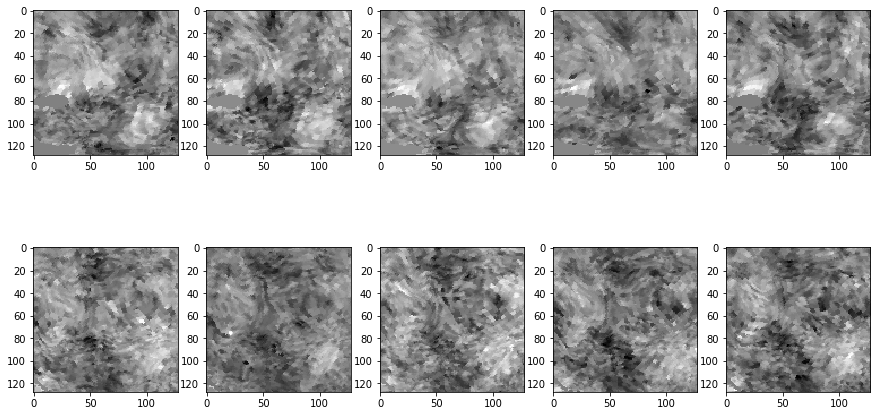

In [72]:
img_lst = []
a = 0
data = []
count = 0
fig, ax = plt.subplots(nrows=visual_maps.shape[0], ncols=5, figsize=(15,8))    

#print (np.mean(data))
img_lst = visual_maps
for i in (img_lst):
    i = i.reshape(5, 16384)
    for j in range (0, 5):
        ax[count][j].imshow(i[j].reshape(128, 128), cmap = "gray")
    count += 1
plt.show()

In [ ]:
# Autocorrelation Plot (Interval range - 1 - 210)

def autocorr1(x, lags):
    '''numpy.corrcoef, partial'''

    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)


def get_autocorr(img1):
    corr_mean = []
    std_err = []
    for j in range (0, 210):
        corr_list = []
        img = img1.flatten()
        corr_list.append(autocorr1(img, [j]))
        std_err.append(np.std(corr_list)/(np.sqrt(len(corr_list))))
        corr_mean.append(np.mean(corr_list))
    return (np.array(corr_mean), np.array(std_err))
            


x_corr, x_se = get_autocorr(x.flatten())
print ("Sample X")
y_corr, y_se = get_autocorr(y.flatten())
print ("Sample Y")
plt.errorbar(np.arange(0, 210, 1), x_corr, color = "red", label = "Sample X", yerr=x_se, fmt = ".")
plt.errorbar(np.arange(0, 210, 1), y_corr, color = "blue", label = "Sample Y", yerr=y_se)
plt.legend()
plt.show()